Populating the interactive namespace from numpy and matplotlib


In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (4.0, 2.)
pylab.rcParams['lines.linewidth'] = 1.0
pylab.rcParams['font.size'] = 12.0
pylab.rcParams['axes.linewidth'] = 1
pylab.rcParams['axes.titlesize'] = '14' 
pylab.rcParams['axes.labelsize'] = '10'
pylab.rcParams['axes.linewidth'] = 1
pylab.rcParams['figure.subplot.wspace'] = 0.5

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn import mixture
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
import itertools
from scipy import linalg
import matplotlib as mpl
import h5py

from detect import detectData



Populating the interactive namespace from numpy and matplotlib


In [2]:
# import socket
# if socket.gethostname() == 'dialga':
#     data_path = '/data/MEA/neuropixel/rawDataSample.bin'
# else:
#     data_path = '/home/cole/rawDataSample.bin'

# data_path = '/data/MEA/LightStim/P29_16_07_14/10.brw'
data_path = '/data/MEA/LightStim/P29_16_07_14/P29_16_05_14_retina02_left_stim3_fullarray_fullfieldHDF5.brw'
# data = h5py.File(data_path, 'r')
# data = np.fromfile(data_path, dtype=np.int16).reshape((1800000,385))


# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames

# num_channels = 4096#385
# num_recording_channels = 4096#374
# spike_delay = 5
# spike_peak_duration = 5
# noise_duration = 2
# noise_amp = 80000 #100
# max_neighbors = 14
# to_localize = True
# cutout_length = 60
# fps = 0#30000
# threshold = 20 #20

# detectData(data_path, num_channels, num_recording_channels, spike_delay, \
#            spike_peak_duration, noise_duration, noise_amp, max_neighbors,
#            to_localize, cutout_length, fps, threshold, maa=0, \
#            maxsl=12, minsl=3, ahpthr=0, data_format='biocam')

In [3]:
# data_path = '/data/MEA/LightStim/P29_16_07_14/10.brw'
# data = h5py.File(data_path, 'r')
from readUtils import openHDF5file, getHDF5params, readHDF5t_100, readHDF5t_101
d = openHDF5file(data_path)
nFrames, sfd, nRecCh, chIndices, file_format = getHDF5params(d)
_num_channels = nRecCh
_num_recording_channels = nRecCh
sf = int(sfd)
if file_format == 100:
  read_function = readHDF5t_100
else:
  read_function = readHDF5t_101


3Brain data format: 100


In [4]:
import ctypes
def get_frames(rf, t0, t1, ch):
    ''' Transposed version for the interpolation method. '''
#     return 2048 - rf['3BData/Raw'][t0:t1,ch] #.flatten('F').astype(ctypes.c_short)
    d = 2048-rf['3BData/Raw'][t0:t1,ch].flatten('F').astype(ctypes.c_short)
    d[d>200] = 0
    return d


In [5]:
sp = np.loadtxt('ProcessedSpikes')

In [6]:
# sp[:,0],sp[:,1]#, sp[:,1]//100*100

In [7]:
f = open('neighbormatrix','r')
neighs = []
for l in f.readlines():
    neighs.append(np.array(l[:-2].split(',')).astype(int))
f.close()
f = open('positions','r')
pos = []
for l in f.readlines():
    pos.append(np.array(l[:-2].split(',')).astype(int))
f.close()

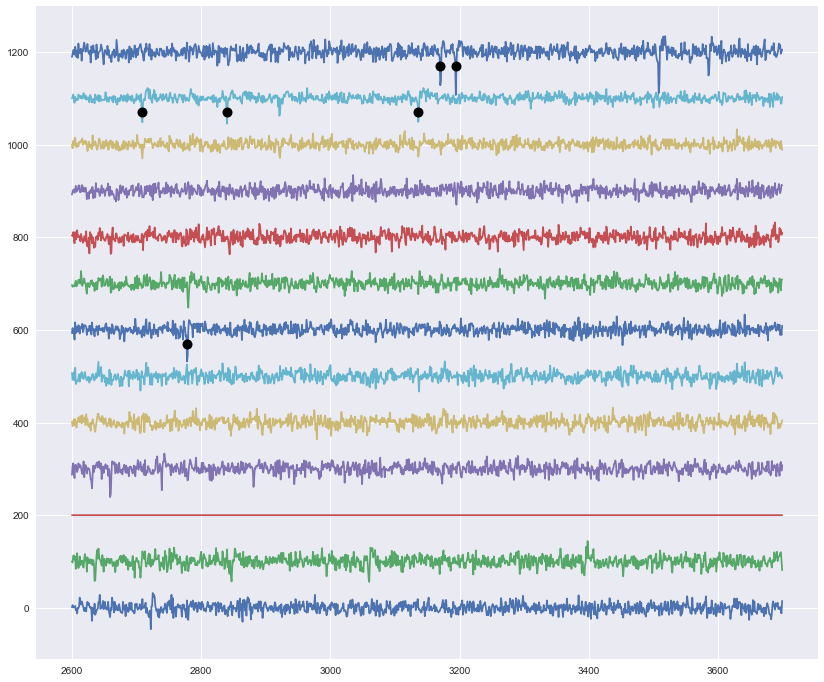

In [8]:
plt.figure(figsize=(14,12))
nsp = 1000
n = neighs[int(sp[nsp,0])]
for i in range(len(n)):
    ch = n[i]#int(sp[0,0]-10)+i
    t1, t2 = np.max((0,int((sp[nsp,1]//100-1)*100))), int((sp[nsp,1]//100+10)*100) #2000, 2700
    inds = np.where((sp[:,0]==ch)&(sp[:,1]>=t1)&(sp[:,1]<t2))[0]
#     inds = np.where((sp[:,1]>=t1)&(sp[:,1]<t2))[0]
    fr = get_frames(d, t1, t2, ch)
#     fr2 = readHDF5t_100(d, 0, 600, 4096)
#     plt.plot(fr[0:800]+i*100)    
    plt.plot(np.arange(t1,t2),fr+i*100)    
    plt.plot(sp[inds,1],np.repeat(i*100-30, len(inds)),'ko',ms=10)
#     plt.plot(fr2[ch::4096]+i*100,'--')

In [9]:
# sp[70,0], pos[np.array(sp[:,0]).astype(int)]

<IPython.core.display.Javascript object>


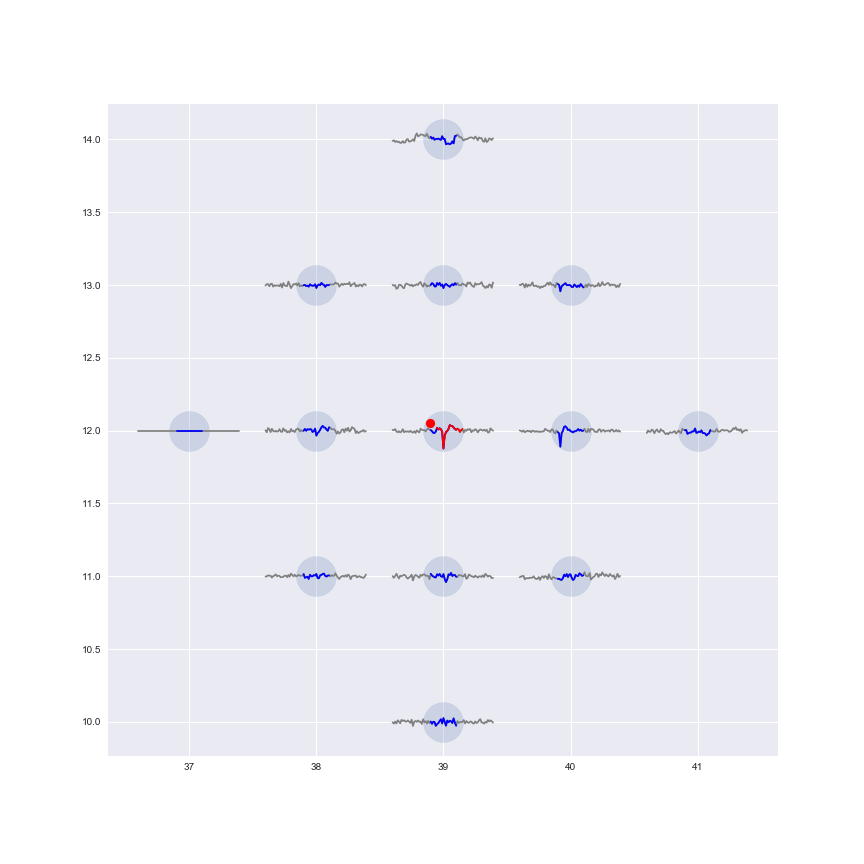

807 241 490988.0 38.8909 12.0517


In [36]:
plt.figure(figsize=(12,12))
for i in (70,):
    ch = int(sp[i,0])
    t = int(sp[i,1])
    a = sp[i,2]
    x = sp[i,3]
    y = sp[i,4]
    print(ch,t,a,x,y)
    cutlen = sp[0].shape[0]-5
    #plt.plot(sp[i][5:])

    plt.scatter(np.array(pos)[neighs[ch],0],np.array(pos)[neighs[ch],1], s=1600, alpha=0.2)    
    
    t1 = np.max((0,t-40))
    t2 = t+40

    # plt.plot(pos[ch][0]+np.arange(t1,t2)/10., pos[ch][1]+data[t1:t2,ch]/10,'r')
    for n in neighs[ch]:
    #     print(n)
        plt.plot(pos[n][0]+np.arange(t2-t1)/100.-0.4,pos[n][1]+get_frames(d,t1,t2,n)/1000.,'gray')
        plt.plot(pos[n][0]+(np.arange(cutlen)+t-t1-10)/100.-0.4,pos[n][1]+get_frames(d,t-10,t+cutlen-10,n)/1000.,'b')
    plt.plot(pos[ch][0]+(np.arange(cutlen)+t-t1-30)/100.+0.25-0.4,pos[ch][1]+sp[i][5:]/1000.,'r')
    plt.scatter(x,y,s=80,c='r')
# plt.axis('equal')

<IPython.core.display.Javascript object>


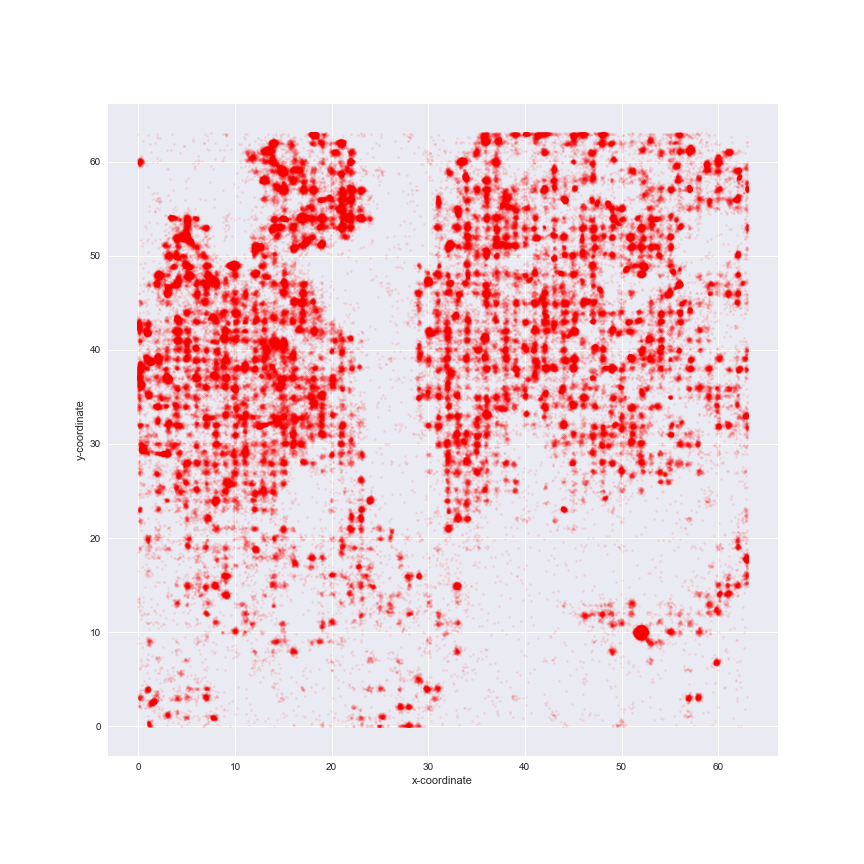

In [12]:
%matplotlib notebook
plt.figure(figsize=(12,12))
plt.plot(sp[:,4], sp[:,3],'r.',ms=5, alpha=0.1)
# plt.axis('equal')
# plt.xlim((775,975))
# plt.ylim((10,60))
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')

In [21]:
cutouts = np.array(sp)[:,5:]
pca = PCA(n_components=2, whiten=True)
cutouts_pca = pca.fit_transform(cutouts)
cutouts_pca.shape

(458112, 2)

In [29]:
sp_pos = np.array(sp)[:,3:5]
fourvec = np.hstack((sp_pos, 0.35*cutouts_pca))
ms = MeanShift(bandwidth = 0.3, bin_seeding=True, min_bin_freq=10, n_jobs=-1)
ms.fit(fourvec)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
# print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

total number of seeds: 8695
seeds/job: 2174
using 4 cpus


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min finished


Number of estimated clusters: 1028


<IPython.core.display.Javascript object>


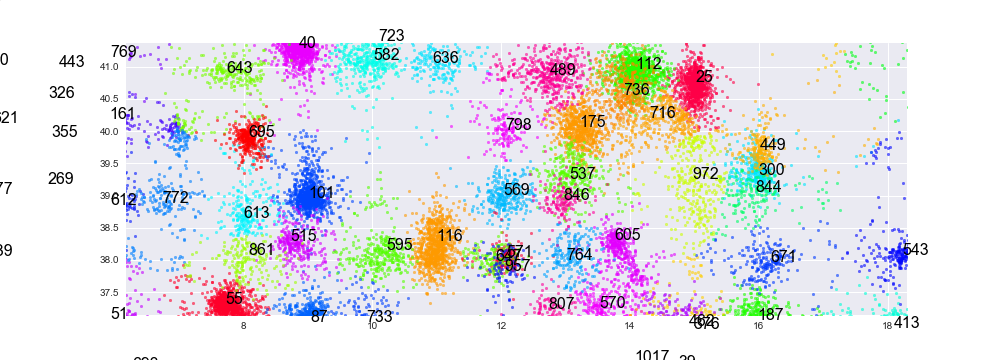

(-3.2841350547495645,
 66.284135054749569,
 -3.5383447568258308,
 66.538344756825836)

In [30]:
%matplotlib notebook
plt.figure(figsize=(14,5))
# colors = 100*['r', 'g', 'b', 'c', 'k', 'y', 'm']
colors = plt.cm.hsv(1.*np.random.permutation(n_clusters_)/n_clusters_)

for cl in np.unique(labels):
    inds = np.where(labels==cl)[0][:1000]
    plt.scatter(sp_pos[inds,1], sp_pos[inds,0], marker='.', color = colors[cl],s=30, alpha=0.6)
    plt.text(cluster_centers[cl,1], cluster_centers[cl,0], str(cl), color='k', fontsize=16)

# plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker="x", color ='k', s=150, linewidths = 5, zorder=10)
plt.axis('equal')
# plt.xlim((800,875))
# plt.xlim((1350,1550))


<IPython.core.display.Javascript object>


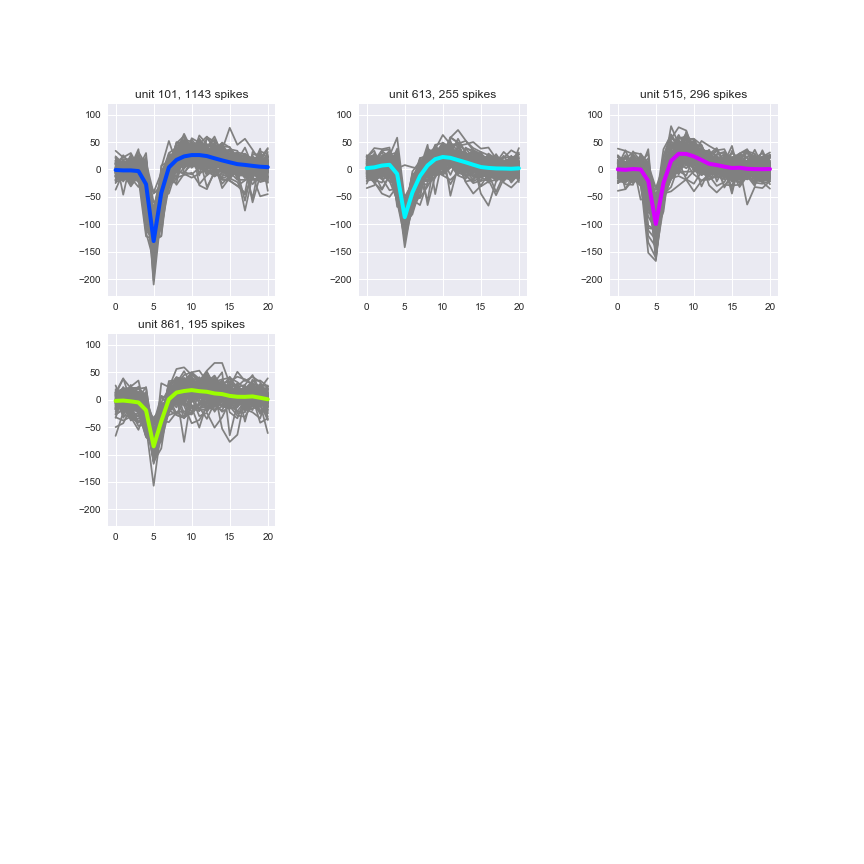

In [33]:
plt.figure(figsize=(12,12))

units = ((101,613,515,861))#range(9)#((4,118))
for i,cl in enumerate(units):
    inds = np.where(labels==cl)[0]
    plt.subplot(3,3,i+1)
    plt.plot(cutouts[inds[:100],:].T,'gray');
    plt.plot(np.mean(cutouts[inds,:],axis=0),c=colors[cl], lw=4);
    plt.title('unit '+str(cl)+', '+str(len(inds))+' spikes')
    plt.ylim((-230,120))